# Sentiment Analysis

## Introduction

Now I'll proceed to analyse the sentiment of the headlines, I'll analyse both polarity and subjectivity. For that I'll be using two different packages **Spacy** and **TextBlob** as well as the package that combines both and allows us to work with them in combination.

Also, as per usual, there are two metrics that sentiment analysis allow us to look at.

* **Polariry:** How positive or negative a word is. It has a range of [-1; 1]
* **Subjectivity:** How opinionated a word might be. It has a range of [0; 1]

Now I'll be looking at sentiment in different ways.

1. **Per tweet:** I'll analyse each tweet by itself.
2. **Per day:** I'll group the tweets per day for each of the newspapers.
3. **Total:** The full corpues will be analysed.

I tried to find a model trained in spanish to make the analysis and found info on the TASS 2015, but I looked for the corpus and couldn't find it. So another opition I had was to transalte the *tweets* to English and then run the analysis. It's not an ideal solution, but given the fact that the analysis is being done in newpaper headlines, we can expect that much of the language used is standard spanish.

Still, this means that the results are to be checked before and to be taken with a grain of salt.

In [50]:
import os
import numpy as np
import pandas as pd
import six

from dotenv import load_dotenv, find_dotenv
from google.cloud import translate_v2 as translate

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

BASE_DIR = os.environ.get("BASE_DIR")

## Sentiment per tweet

In [3]:
tweet_data = pd.read_pickle(f'{BASE_DIR}/data/interim/data_clean.pkl')
tweet_data.drop(['possibly_sensitive', 'referenced_tweets', 'text'], axis=1, inplace=True)
tweet_data.rename(columns={'text_clean': 'text_spa'}, inplace=True)
tweet_data.reset_index(inplace=True)
tweet_data.tail()

,index,created_at,id,retweet_count,reply_count,like_count,quote_count,newspaper,text_spa
15862,1201,2020-12-01 05:21:11+00:00,1333642276388605957,0,0,3,0,larazon_pe,el portero leaobutrón afirmó que su decisión e...
15863,1202,2020-12-01 04:57:34+00:00,1333636332221059074,1,0,4,0,larazon_pe,universitariodedeportes venció binacional disp...
15864,1203,2020-12-01 04:42:36+00:00,1333632569729044480,0,0,3,0,larazon_pe,cerca de la navidad el instituto nacional de s...
15865,1204,2020-12-01 03:59:32+00:00,1333621728984133632,1,0,6,0,larazon_pe,los turistas nacionales podrán acceder la tari...
15866,1206,2020-12-01 03:05:43+00:00,1333608187010965504,1,0,0,0,larazon_pe,el ministerio del interior mininter descartó l...


In [12]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15867 entries, 0 to 1206
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   created_at     15867 non-null  datetime64[ns, UTC]
 1   id             15867 non-null  object             
 2   retweet_count  15867 non-null  int64              
 3   reply_count    15867 non-null  int64              
 4   like_count     15867 non-null  int64              
 5   quote_count    15867 non-null  int64              
 6   newspaper      15867 non-null  object             
 7   text_spa       15867 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(3)
memory usage: 1.3+ MB


### Tweet translation

I used the google API to make the translations. And they took a huge aommount of time (3 to 4 hours to complete).

In [3]:
def translate_text(target, text):
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """

    translate_client = translate.Client()

    if isinstance(text, six.binary_type):
        text = text.decode("utf-8")

    return translate_client.translate(text, target_language=target)

In [ ]:
text_eng = []
for tweet_text in tweet_data.text_spa:
    text_eng.append(translate_text("en", tweet_text))

Ran the first batch and got just the first `15181` translation, missing some, so I'll run the fucnrion again for the rest. But first, save what I have already gotten.

In [30]:
import json

with open(f"{BASE_DIR}/data/external/eng_translation.json", "w") as file:
    json.dump(text_eng, file)

In [28]:
for tweet_text in tweet_data.text_spa.iloc[15181:]:
    text_eng.append(translate_text("en", tweet_text))

In [37]:
tweet_data["text_eng"] = text_eng

0        keiko fujimori fills me with enthusiasm energy...
1        Lima metro line new hours before curfew extension
2             police the us military face internal enemies
3                          old cars in the streets of Lima
4        sporting cristal made the return of jesús pret...
                               ...                        
15862    the goalkeeper leaobutrón affirmed that his de...
15863    universitariodeportes won binational will cont...
15864    around Christmas the national institute of hea...
15865    national tourists will be able to access the r...
15866    the interior ministry mininter ruled out the p...
Name: text_eng, Length: 15867, dtype: object

In [6]:
tweet_data["text_eng"] = tweet_data["text_eng"].apply(lambda x: x["translatedText"])
tweet_data.head()

,index,created_at,id,retweet_count,reply_count,like_count,quote_count,newspaper,text_spa,text_eng
0,0,2021-01-14 23:58:50+00:00,1349868608600608768,6,101,47,6,elcomercio_peru,keiko fujimori me llena de ilusión energía hab...,keiko fujimori fills me with enthusiasm energy...
1,1,2021-01-14 23:55:38+00:00,1349867803319402499,1,0,4,0,elcomercio_peru,línea del metro de lima nuevo horario ante amp...,Lima metro line new hours before curfew extension
2,2,2021-01-14 23:52:31+00:00,1349867020121214978,2,0,2,0,elcomercio_peru,la policía los militares de eeuu se enfrentan ...,police the us military face internal enemies
3,3,2021-01-14 23:49:25+00:00,1349866239481556992,2,0,11,0,elcomercio_peru,autos antiguos en las calles limeñas,old cars in the streets of Lima
4,4,2021-01-14 23:46:13+00:00,1349865436259774466,0,0,5,0,elcomercio_peru,sporting cristal oficializó el regreso de jesú...,sporting cristal made the return of jesús pret...


In [7]:
tweet_data.to_pickle(f"{BASE_DIR}/data/interim/translated_tweets.pkl")

In [13]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15867 entries, 0 to 15866
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   index          15867 non-null  int64              
 1   created_at     15867 non-null  datetime64[ns, UTC]
 2   id             15867 non-null  object             
 3   retweet_count  15867 non-null  int64              
 4   reply_count    15867 non-null  int64              
 5   like_count     15867 non-null  int64              
 6   quote_count    15867 non-null  int64              
 7   newspaper      15867 non-null  object             
 8   text_spa       15867 non-null  object             
 9   text_eng       15867 non-null  object             
 10  polarity       15867 non-null  float64            
 11  subjectivity   15867 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(4)
memory usage: 1.5+ MB


In [1]:
from textblob import TextBlob

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

In [8]:
tweet_data["polarity"] = tweet_data["text_eng"].apply(polarity)
tweet_data["subjectivity"] = tweet_data["text_eng"].apply(subjectivity)

In [25]:
sentiment_summary = tweet_data.groupby(by="newspaper")[["polarity", "subjectivity"]].describe()
sentiment_summary

polarity                                                    \
                   count      mean       std  min  25%  50%       75%  max   
newspaper                                                                    
DiarioElPeruano   1660.0  0.098844  0.188693 -0.6  0.0  0.0  0.195833  1.0   
ExpresoPeru       2225.0  0.038735  0.197326 -1.0  0.0  0.0  0.033333  1.0   
Gestionpe         2036.0  0.042978  0.200515 -1.0  0.0  0.0  0.076250  1.0   
diariocorreo      1884.0  0.047867  0.205013 -1.0  0.0  0.0  0.100000  1.0   
diarioojo         2039.0  0.060972  0.264835 -1.0  0.0  0.0  0.150000  1.0   
elcomercio_peru    798.0  0.058771  0.222822 -1.0  0.0  0.0  0.136364  1.0   
larazon_pe        1004.0  0.064568  0.199552 -0.8  0.0  0.0  0.125000  1.0   
larepublica_pe    1403.0  0.052647  0.192637 -0.8  0.0  0.0  0.115909  1.0   
peru21noticias    1043.0  0.047852  0.203439 -1.0  0.0  0.0  0.100000  1.0   
tromepe           1775.0  0.049007  0.258568 -1.0  0.0  0.0  0.136364  1.0   

                subjectivity                                          \
                       count      mean       std  min  25%       50%   
newspaper                                                              
DiarioElPeruano       1660.0  0.257911  0.270699  0.0  0.0  0.200000   
ExpresoPeru           2225.0  0.200955  0.278014  0.0  0.0  0.000000   
Gestionpe             2036.0  0.225200  0.282228  0.0  0.0  0.066667   
diariocorreo          1884.0  0.218951  0.286483  0.0  0.0  0.000000   
diarioojo             2039.0  0.288010  0.312468  0.0  0.0  0.200000   
elcomercio_peru        798.0  0.254124  0.304774  0.0  0.0  0.100000   
larazon_pe            1004.0  0.256005  0.279101  0.0  0.0  0.200000   
larepublica_pe        1403.0  0.261168  0.271833  0.0  0.0  0.200000   
peru21noticias        1043.0  0.224960  0.290899  0.0  0.0  0.000000   
tromepe               1775.0  0.289871  0.310208  0.0  0.0  0.220833   

                                
                      75%  max  
newspaper                       
DiarioElPeruano  0.454545  1.0  
ExpresoPeru      0.400000  1.0  
Gestionpe        0.437500  1.0  
diariocorreo     0.416667  1.0  
diarioojo        0.500000  1.0  
elcomercio_peru  0.454545  1.0  
larazon_pe       0.458333  1.0  
larepublica_pe   0.454545  1.0  
peru21noticias   0.426136  1.0  
tromepe          0.500000  1.0

In [28]:
tweet_data["created_date"] = tweet_data["created_at"].apply(lambda x: x.date)

In [32]:
sentiment_summary_daily = tweet_data.groupby(by=["newspaper", "created_date"])[["polarity", "subjectivity"]].describe()
sentiment_summary_daily

polarity                                     \
                                count      mean       std       min  25%   
newspaper       created_date                                               
DiarioElPeruano 2020-12-01       52.0  0.100746  0.235953 -0.500000  0.0   
                2020-12-02       51.0  0.100195  0.208571 -0.300000  0.0   
                2020-12-03       47.0  0.073548  0.192001 -0.283333  0.0   
                2020-12-04       51.0  0.091075  0.169850 -0.300000  0.0   
                2020-12-05       30.0  0.128467  0.179869 -0.200000  0.0   
...                               ...       ...       ...       ...  ...   
tromepe         2021-01-10      108.0  0.069672  0.302581 -0.900000  0.0   
                2021-01-11      103.0  0.075689  0.217462 -0.600000  0.0   
                2021-01-12      101.0  0.077043  0.275430 -0.729167  0.0   
                2021-01-13      112.0  0.014951  0.253343 -1.000000  0.0   
                2021-01-14      116.0  0.031731  0.253491 -0.750000  0.0   

                                                           subjectivity  \
                                   50%       75%       max        count   
newspaper       created_date                                              
DiarioElPeruano 2020-12-01    0.087500  0.200694  0.900000         52.0   
                2020-12-02    0.000000  0.158333  1.000000         51.0   
                2020-12-03    0.000000  0.129167  0.700000         47.0   
                2020-12-04    0.000000  0.164646  0.666667         51.0   
                2020-12-05    0.103333  0.237500  0.500000         30.0   
...                                ...       ...       ...          ...   
tromepe         2021-01-10    0.000000  0.200000  1.000000        108.0   
                2021-01-11    0.000000  0.163988  1.000000        103.0   
                2021-01-12    0.000000  0.200000  1.000000        101.0   
                2021-01-13    0.000000  0.071970  0.550000        112.0   
                2021-01-14    0.000000  0.100000  1.000000        116.0   

                                                                           \
                                  mean       std  min       25%       50%   
newspaper       created_date                                                
DiarioElPeruano 2020-12-01    0.294735  0.235717  0.0  0.072917  0.300000   
                2020-12-02    0.277796  0.291478  0.0  0.000000  0.200000   
                2020-12-03    0.283087  0.258760  0.0  0.000000  0.300000   
                2020-12-04    0.239648  0.280771  0.0  0.000000  0.175000   
                2020-12-05    0.253196  0.240506  0.0  0.000000  0.225000   
...                                ...       ...  ...       ...       ...   
tromepe         2021-01-10    0.299946  0.323330  0.0  0.000000  0.200000   
                2021-01-11    0.289470  0.309034  0.0  0.000000  0.200000   
                2021-01-12    0.283546  0.306145  0.0  0.000000  0.200000   
                2021-01-13    0.270413  0.317555  0.0  0.000000  0.100000   
                2021-01-14    0.284369  0.306964  0.0  0.000000  0.210417   

                                             
                                   75%  max  
newspaper       created_date                 
DiarioElPeruano 2020-12-01    0.475000  1.0  
                2020-12-02    0.483333  1.0  
                2020-12-03    0.477273  1.0  
                2020-12-04    0.400000  1.0  
                2020-12-05    0.400000  0.8  
...                                ...  ...  
tromepe         2021-01-10    0.508333  1.0  
                2021-01-11    0.500000  1.0  
                2021-01-12    0.500000  1.0  
                2021-01-13    0.500000  1.0  
                2021-01-14    0.500000  1.0  

[247 rows x 16 columns]

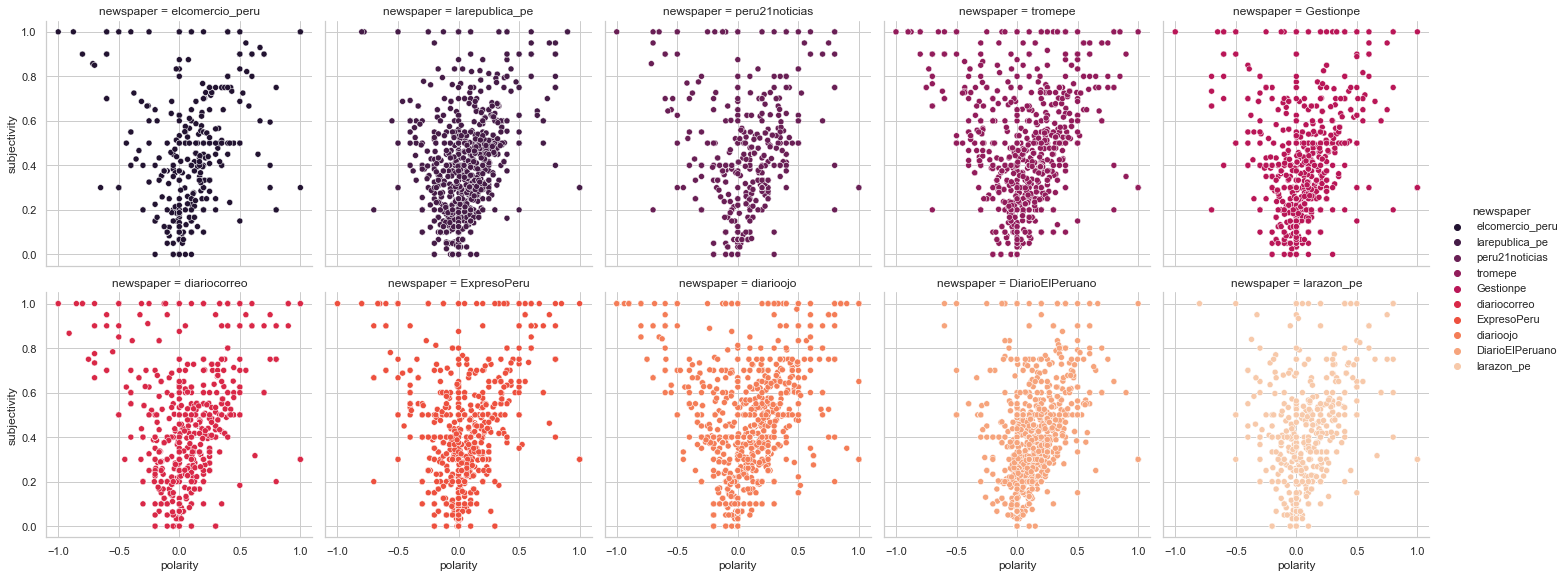

In [16]:
import seaborn as sns

sns.set_theme(style="whitegrid")

sns.relplot(
    x="polarity",
    y="subjectivity",
    col="newspaper",
    hue="newspaper",
    data=tweet_data,
    col_wrap=5,
    palette="rocket",
    height=4
)

What I found was a V-shape originating on zero polarity and subjectivity and the polarity increases for both sides as the subjectivity increases.

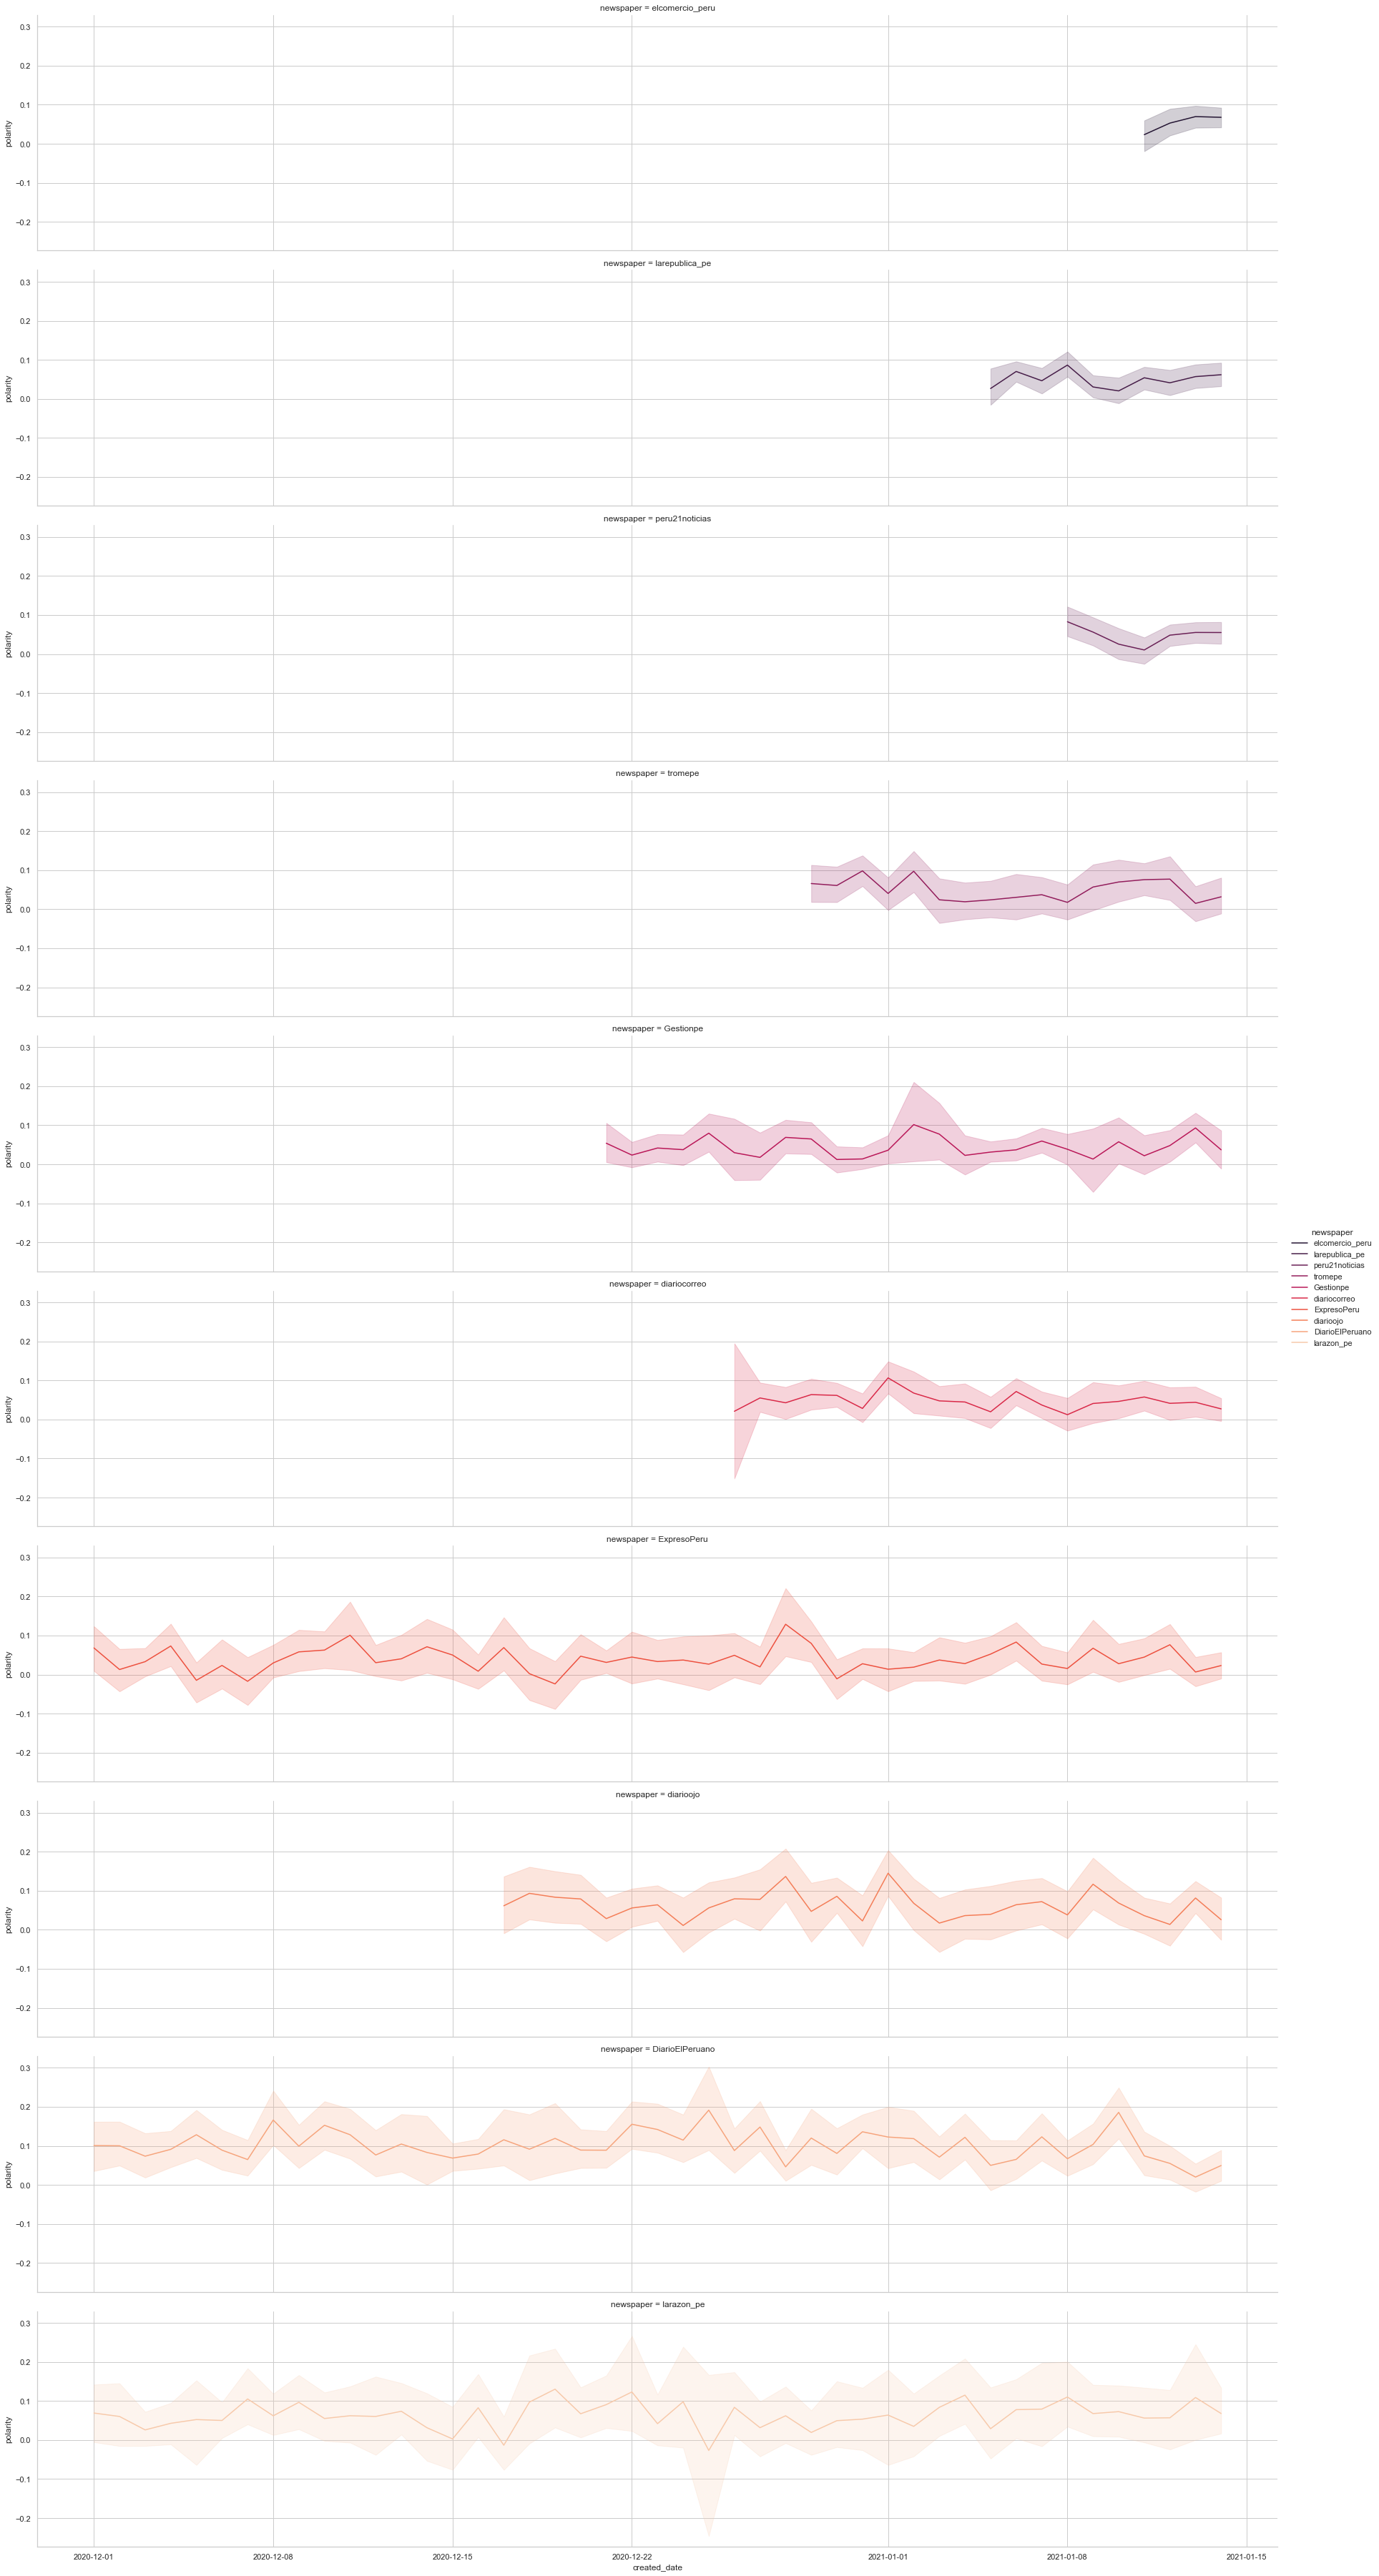

In [40]:
sns.relplot(
    x="created_date",
    y="polarity",
    col="newspaper",
    hue="newspaper",
    data=tweet_data,
    kind="line",
    col_wrap=1,
    palette="rocket",
    aspect=5
)

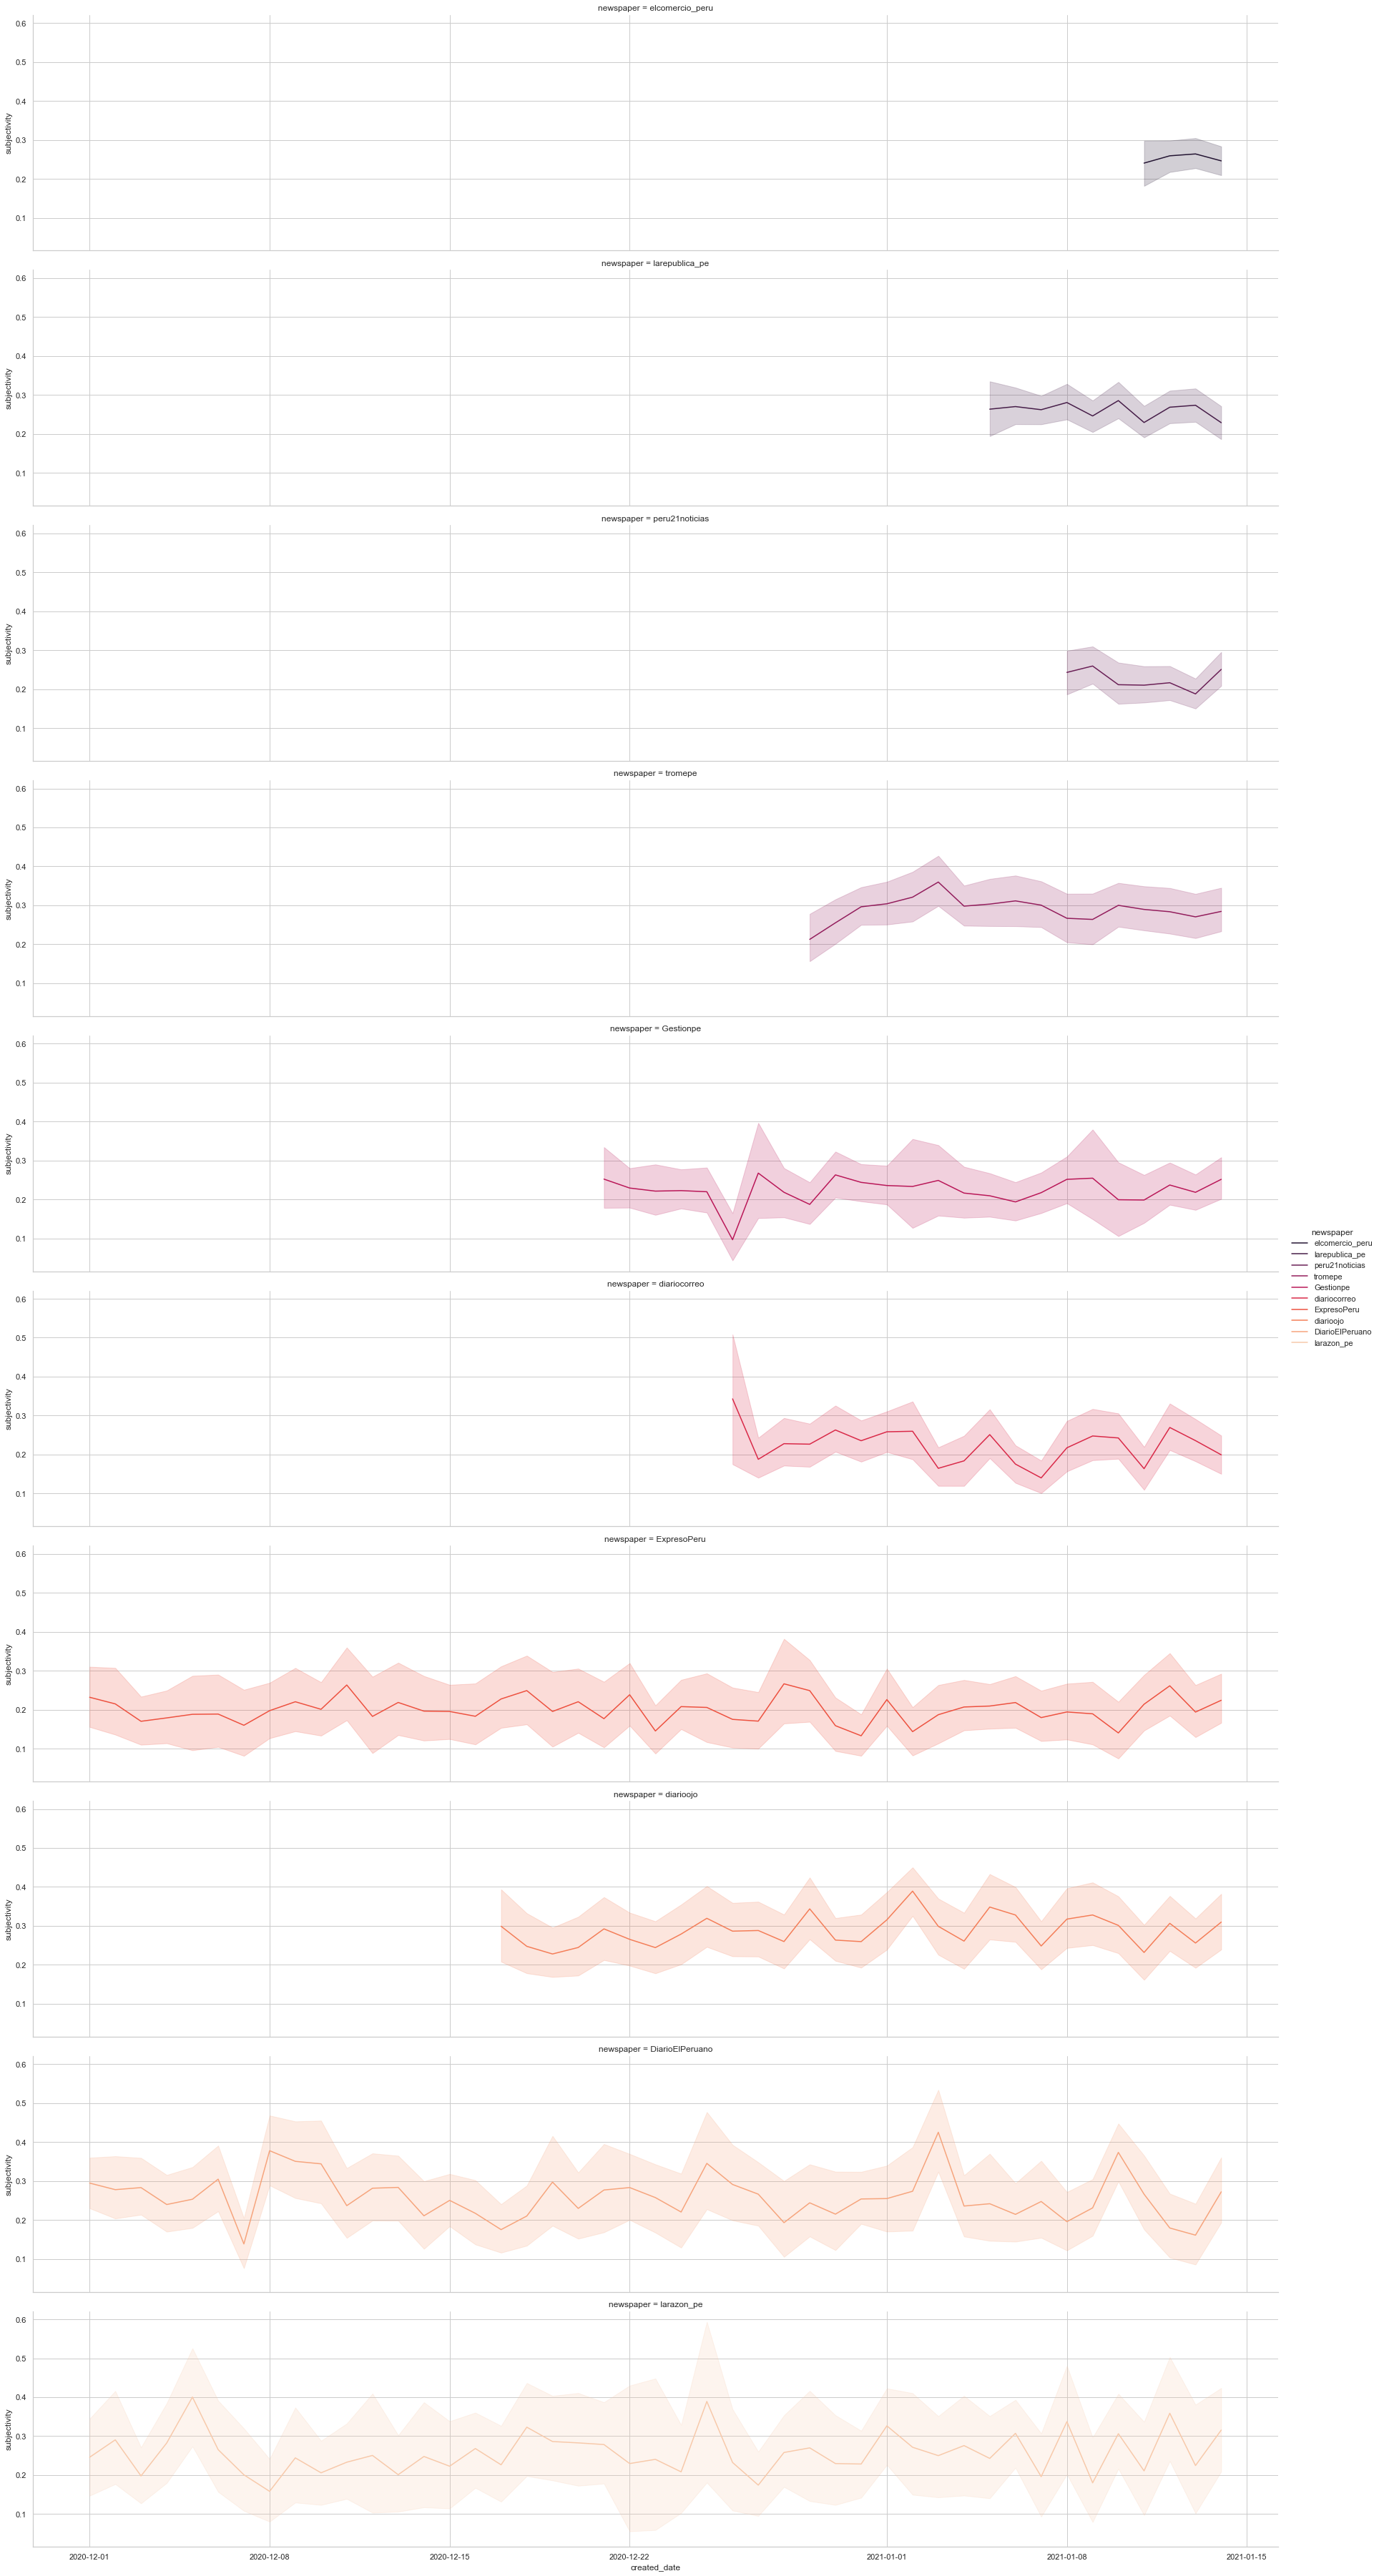

In [41]:
sns.relplot(
    x="created_date",
    y="subjectivity",
    col="newspaper",
    hue="newspaper",
    kind="line",
    data=tweet_data,
    col_wrap=1,
    palette="rocket",
    aspect=5
)

In [78]:
tweet_data["text_len"] = tweet_data["text_spa"].apply(lambda x: len(x))

In [80]:
tweet_data.to_pickle(f"{BASE_DIR}/data/interim/sentiment_analysis.pkl")

In [81]:
tweet_numerical = tweet_data[["newspaper", "retweet_count", "reply_count", "like_count", "quote_count", "polarity", "subjectivity", "text_len"]]
group_numerical_tweet = tweet_numerical.groupby(by="newspaper")

In [82]:
numerical_corr = group_numerical_tweet.corr()
numerical_corr

retweet_count  reply_count  like_count  \
newspaper                                                               
DiarioElPeruano retweet_count       1.000000     0.214719    0.359982   
                reply_count         0.214719     1.000000    0.657381   
                like_count          0.359982     0.657381    1.000000   
                quote_count         0.369721     0.653505    0.935075   
                polarity           -0.011875    -0.033181   -0.010960   
...                                      ...          ...         ...   
tromepe         like_count          0.876967     0.671745    1.000000   
                quote_count         0.624376     0.659076    0.672399   
                polarity           -0.034884    -0.000265   -0.005623   
                subjectivity       -0.031406    -0.020394   -0.022504   
                text_len           -0.012010     0.033656   -0.003647   

                               quote_count  polarity  subjectivity  text_len  
newspaper                                                                     
DiarioElPeruano retweet_count     0.369721 -0.011875      0.004785 -0.081471  
                reply_count       0.653505 -0.033181      0.019739 -0.035322  
                like_count        0.935075 -0.010960      0.020421 -0.049501  
                quote_count       1.000000 -0.021684      0.018947 -0.039089  
                polarity         -0.021684  1.000000      0.447861  0.071843  
...                                    ...       ...           ...       ...  
tromepe         like_count        0.672399 -0.005623     -0.022504 -0.003647  
                quote_count       1.000000 -0.006768      0.005744  0.013610  
                polarity         -0.006768  1.000000      0.112079 -0.020575  
                subjectivity      0.005744  0.112079      1.000000  0.127408  
                text_len          0.013610 -0.020575      0.127408  1.000000  

[70 rows x 7 columns]

In [67]:
set(numerical_corr.index.get_level_values(0))

{'DiarioElPeruano',
 'ExpresoPeru',
 'Gestionpe',
 'diariocorreo',
 'diarioojo',
 'elcomercio_peru',
 'larazon_pe',
 'larepublica_pe',
 'peru21noticias',
 'tromepe'}

In [69]:
numerical_corr.loc["Gestionpe"]

,retweet_count,reply_count,like_count,quote_count,polarity,subjectivity
retweet_count,1.000000,0.777525,0.834854,0.774393,0.011698,-0.005265
reply_count,0.777525,1.000000,0.666630,0.862606,0.012269,-0.028763
like_count,0.834854,0.666630,1.000000,0.582025,0.015138,-0.017676
quote_count,0.774393,0.862606,0.582025,1.000000,0.017278,-0.000357
polarity,0.011698,0.012269,0.015138,0.017278,1.000000,0.191587
subjectivity,-0.005265,-0.028763,-0.017676,-0.000357,0.191587,1.000000


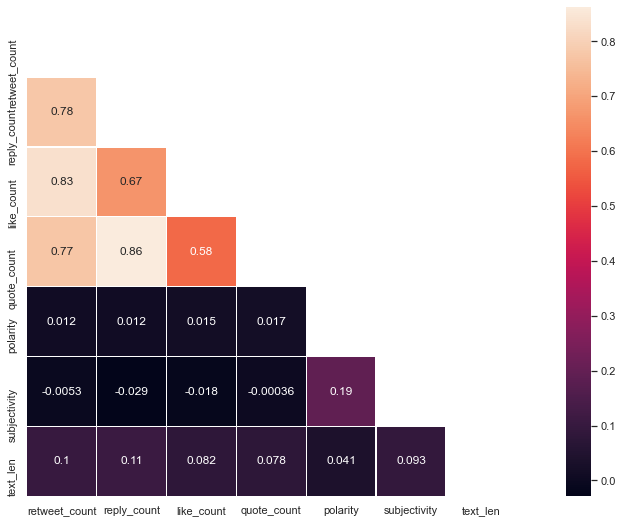

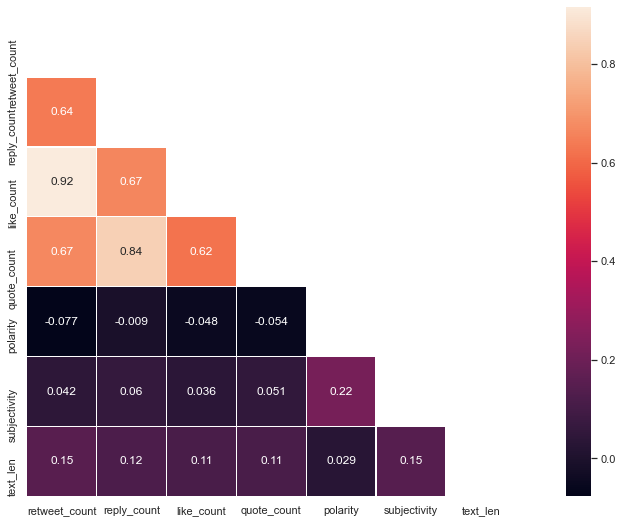

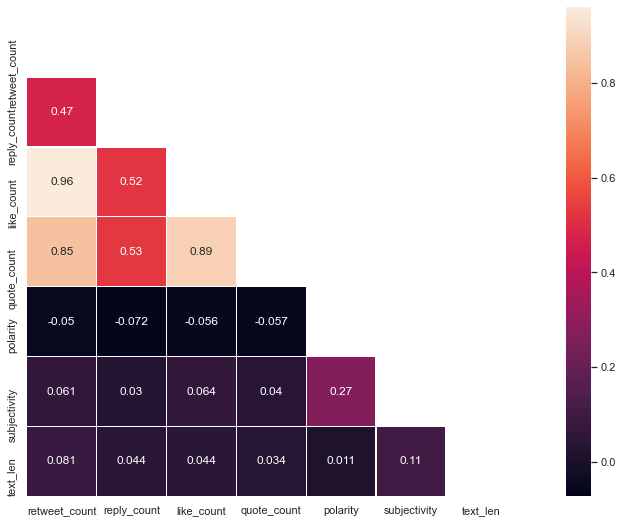

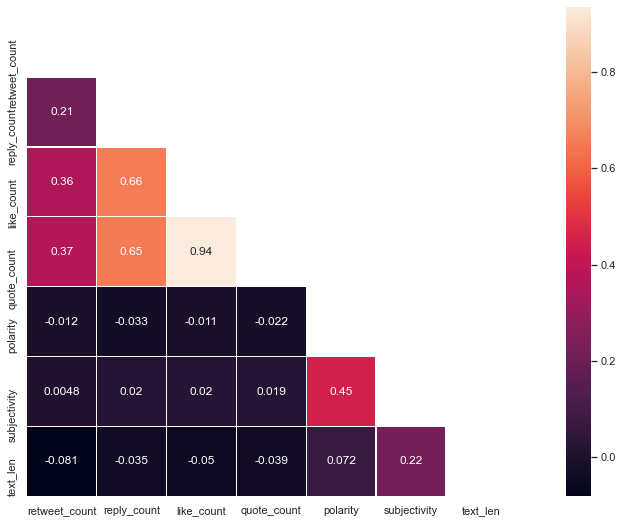

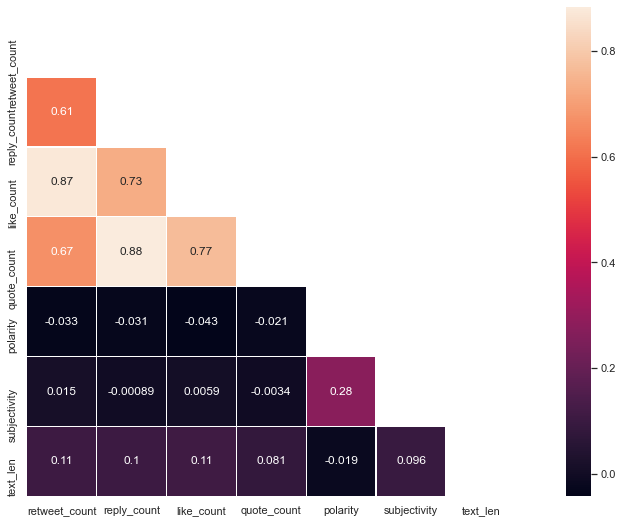

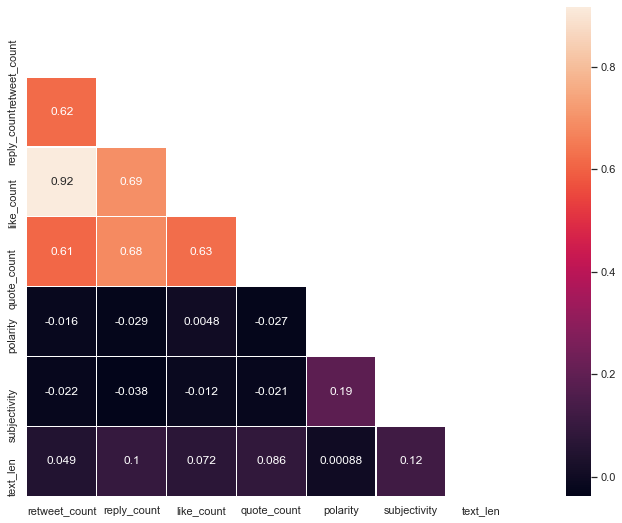

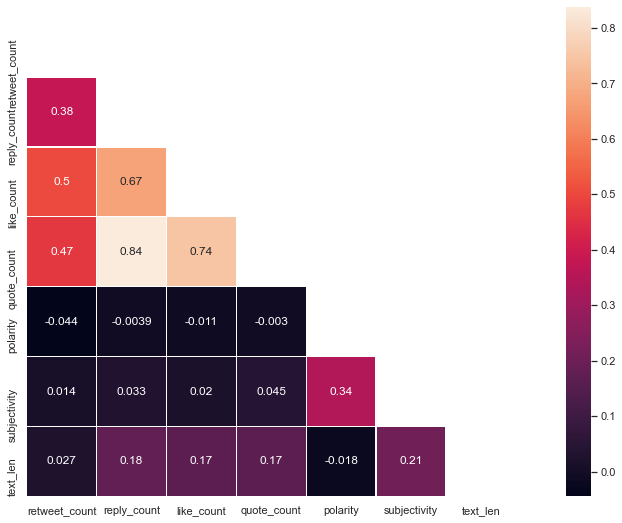

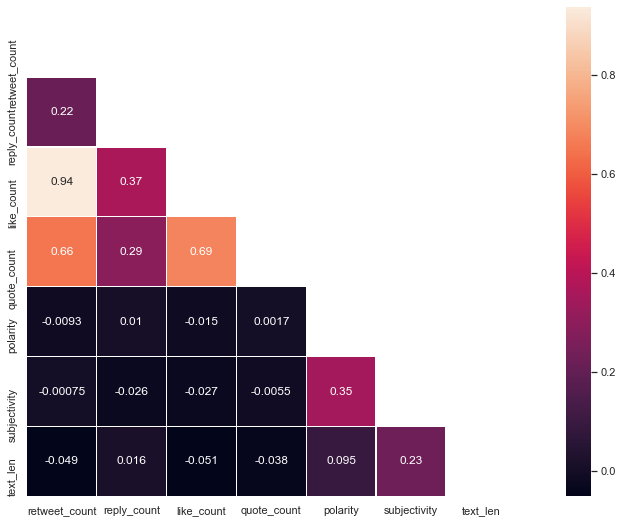

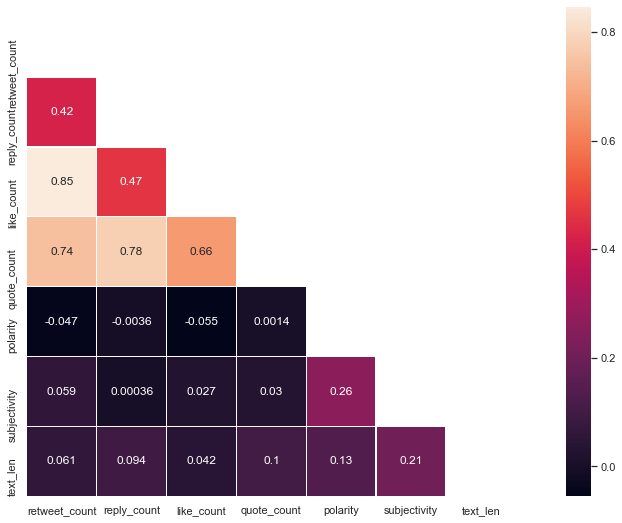

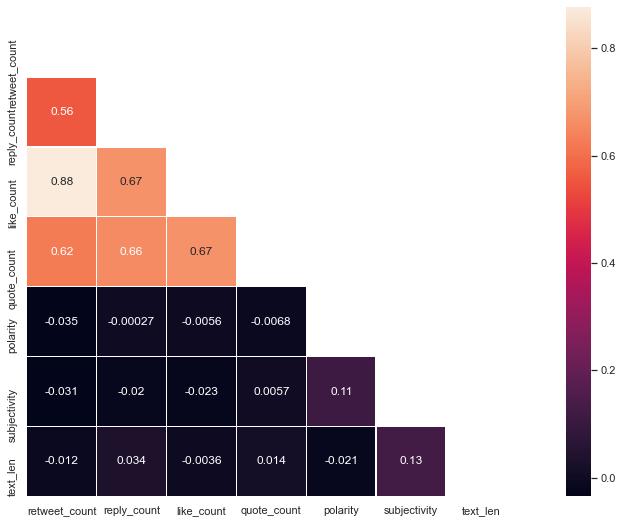

In [83]:
for newspaper in set(numerical_corr.index.get_level_values(0)):
    mask = np.triu(np.ones_like(numerical_corr.loc[newspaper], dtype=bool))
    f, ax = plt.subplots(figsize=(18, 9))

    sns.heatmap(numerical_corr.loc[newspaper], mask=mask, square=True, linewidths=.5, cmap="rocket", annot=True)